In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Importing the Dataset

In [2]:
data = pd.read_csv('segmentation data.csv')

In [3]:
data.shape

(2000, 8)

In [4]:
data.drop(['ID'], inplace=True, axis=1)

In [5]:
data.head(10)

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,0,0,67,2,124670,1,2
1,1,1,22,1,150773,1,2
2,0,0,49,1,89210,0,0
3,0,0,45,1,171565,1,1
4,0,0,53,1,149031,1,1
5,0,0,35,1,144848,0,0
6,0,0,53,1,156495,1,1
7,0,0,35,1,193621,2,1
8,0,1,61,2,151591,0,0
9,0,1,28,1,174646,2,0


In [6]:
data.describe()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
count,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000
mean,0.457000,0.496500,35.909000,1.03800,120954.419000,0.810500,0.739000
std,0.498272,0.500113,11.719402,0.59978,38108.824679,0.638587,0.812533
min,0.000000,0.000000,18.000000,0.00000,35832.000000,0.000000,0.000000
25%,0.000000,0.000000,27.000000,1.00000,97663.250000,0.000000,0.000000
50%,0.000000,0.000000,33.000000,1.00000,115548.500000,1.000000,1.000000
75%,1.000000,1.000000,42.000000,1.00000,138072.250000,1.000000,1.000000
max,1.000000,1.000000,76.000000,3.00000,309364.000000,2.000000,2.000000


In [7]:
data.isna().sum()

Sex                0
Marital status     0
Age                0
Education          0
Income             0
Occupation         0
Settlement size    0
dtype: int64

## Exploratory Data Analysis

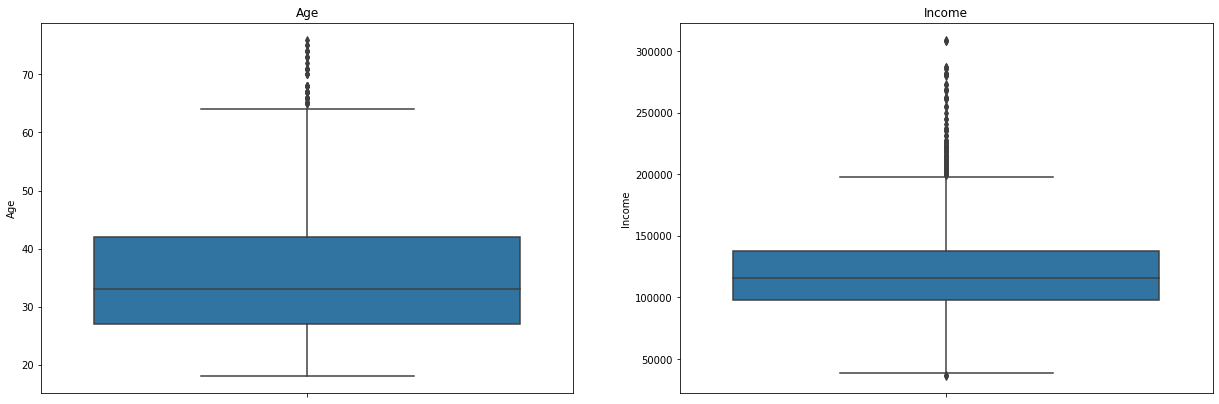

In [8]:
plt.figure(figsize=(21,15))

plt.subplot2grid((2,2), (0,0))
box1 = sns.boxplot(y=data.Age)
plt.title("Age")

plt.subplot2grid((2,2), (0,1))
box2 = sns.boxplot(y=data.Income)
plt.title("Income")

plt.show()

In [9]:
data.Age.describe()

count    2000.000000
mean       35.909000
std        11.719402
min        18.000000
25%        27.000000
50%        33.000000
75%        42.000000
max        76.000000
Name: Age, dtype: float64

In [10]:
data.Income.describe()

count      2000.000000
mean     120954.419000
std       38108.824679
min       35832.000000
25%       97663.250000
50%      115548.500000
75%      138072.250000
max      309364.000000
Name: Income, dtype: float64

### Inferences
- Mean age is approximately 36 years. Max is 76 meanwhile Min is 18
- Mean income is 121k. Max is 310k meanwhile Min is 36k

### Proportion of data values in each feature

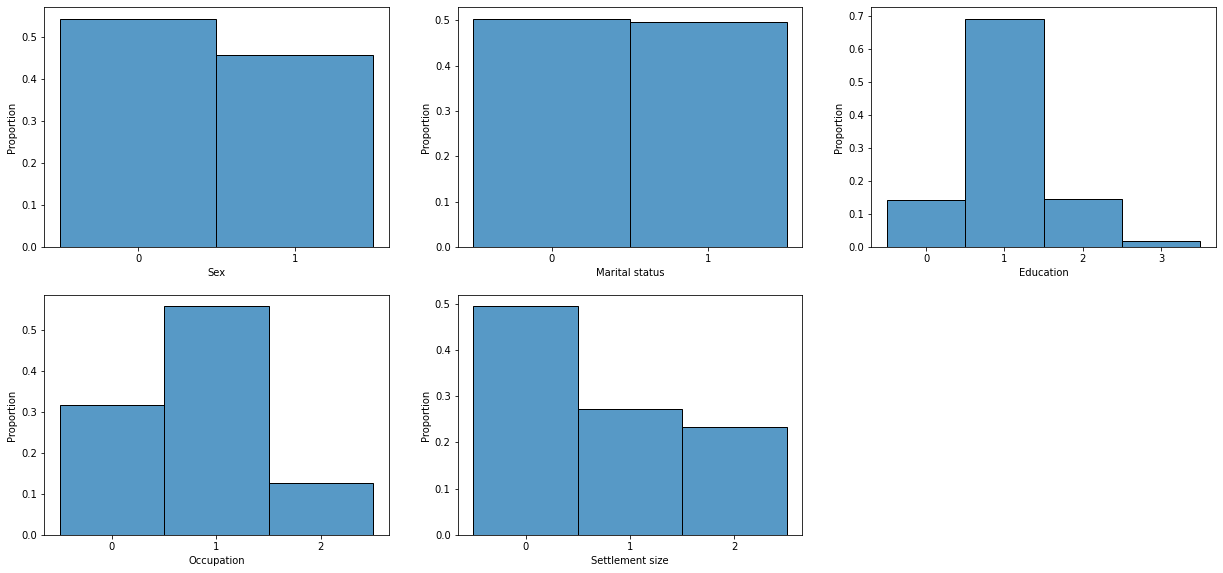

In [11]:
plt.figure(figsize=(21,15))

plt.subplot2grid((3,3), (0,0))
sns.histplot(data.Sex.astype(str), stat='proportion')

plt.subplot2grid((3,3), (0,1))
sns.histplot(data['Marital status'].astype(str), stat='proportion')

plt.subplot2grid((3,3), (0,2))
sns.histplot(data.Education.astype(str).sort_values(), stat='proportion')

plt.subplot2grid((3,3), (1,0))
sns.histplot(data.Occupation.astype(str).sort_values(), stat='proportion')

plt.subplot2grid((3,3), (1,1))
sns.histplot(data['Settlement size'].astype(str).sort_values(), stat='proportion')

plt.show()

## K Means Model

In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [13]:
wcss = {'wcss_score':[], 'no_of_clusters':[]}
for i in range(1,11):
    kmeans = KMeans(i, random_state=0)
    kmeans.fit(data)
    wcss['wcss_score'].append(kmeans.inertia_)
    wcss['no_of_clusters'].append(i)
wcss_df = pd.DataFrame(wcss)

In [14]:
wcss_df.head(10)

,wcss_score,no_of_clusters
0,2.903113e+12,1
1,1.214580e+12,2
2,6.730437e+11,3
3,3.771293e+11,4
4,2.489869e+11,5
5,1.766212e+11,6
6,1.296322e+11,7
7,9.631701e+10,8
8,7.855599e+10,9
9,6.450587e+10,10


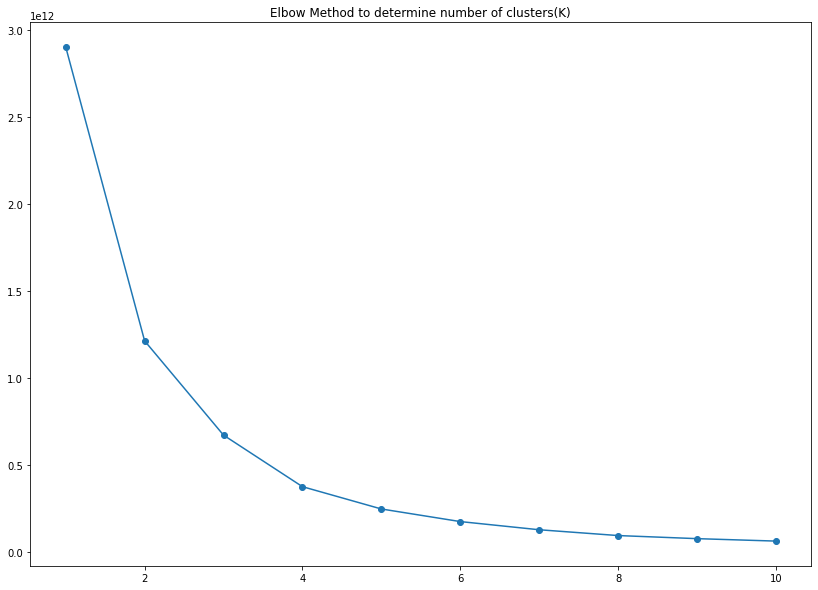

In [15]:
plt.figure(figsize=(14,10))
plt.plot(wcss_df.no_of_clusters, wcss_df.wcss_score, marker='o')
plt.title("Elbow Method to determine number of clusters(K)")
plt.show()

### Inference
Number of clusters in this dataset are 4
- K = 4

In [16]:
kmeans_final = KMeans(n_clusters=4, random_state=0, init='k-means++')
classlabels = kmeans_final.fit_predict(data)

In [17]:
data['classlabels'] = classlabels
data.classlabels = data.classlabels.astype(str)
data = data.sort_values('classlabels')

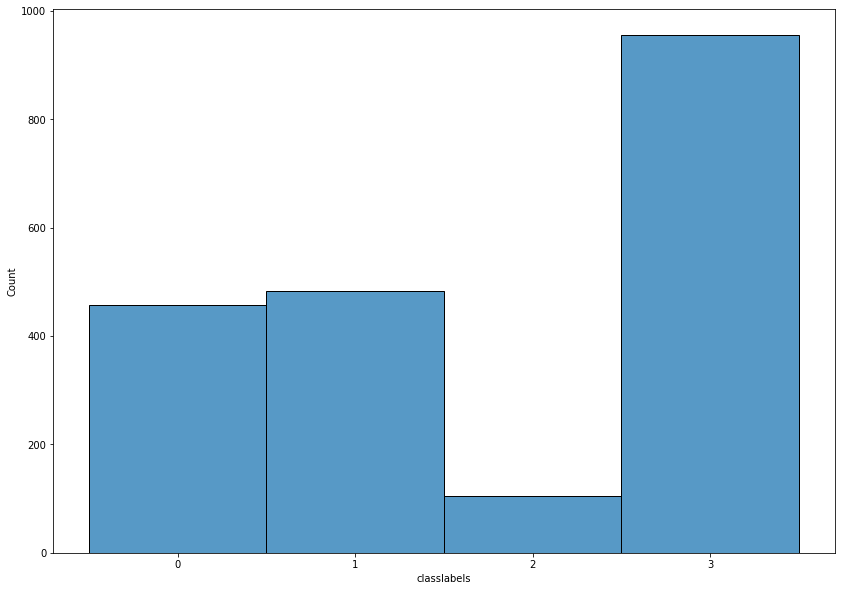

In [18]:
plt.figure(figsize=(14,10))
sns.histplot(data.classlabels)
plt.show()

In [19]:
score = silhouette_score(data, kmeans_final.labels_, random_state=0)
print(f"Silhouette score: {score:0.3f} ~ 0")

Silhouette score: -0.070 ~ 0


Silhouette score of 0 means our model did not work very well. The worse could be -1, but the best can go upto 1.

## Hierarchical clustering - Agglomerative

To improve the clustering model, we move to hierarchical clustering

In [25]:
new_data = data.drop(['classlabels'], axis=1)

In [22]:
from sklearn.cluster import AgglomerativeClustering

### Distances and Linkages
With multiple computation options for both distance and linkage in clusters, we calculate the silhouette score for all permutations

In [32]:
## function to compute scores for all permutations
def s_score(distance, linkage):
    agc = AgglomerativeClustering(n_clusters=4, affinity=distance, linkage=linkage)
    agc.fit_predict(new_data)
    score = silhouette_score(new_data, agc.labels_, random_state=0)
    return score

In [38]:
distances = ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']
linkages = ['ward', 'complete', 'average', 'single']

In [39]:
scoring = {'dist':[], 'link':[], 'sScore':[]}
for i in distances:
    for j in linkages:
        try:
            score = s_score(i, j)
            scoring['dist'].append(i)
            scoring['link'].append(j)
            scoring['sScore'].append(score)
        except:
            scoring['dist'].append(i)
            scoring['link'].append(j)
            scoring['sScore'].append(np.nan)
scoringDf = pd.DataFrame(scoring)


We put this process in try-except block since 'ward' only works with 'euclidean' distance. We can now find the best permutation.

In [43]:
scoringDf.dropna(axis=0, inplace=True)

In [44]:
scoringDf.head(20)

,dist,link,sScore
0,euclidean,ward,0.531762
1,euclidean,complete,0.528703
2,euclidean,average,0.514481
3,euclidean,single,0.703858
5,l1,complete,0.524776
6,l1,average,0.533594
7,l1,single,0.703858
9,l2,complete,0.528703
10,l2,average,0.514481
11,l2,single,0.703858


In [49]:
final_result = scoringDf[scoringDf['sScore'] == max(scoringDf['sScore'])]
final_result

,dist,link,sScore
3,euclidean,single,0.703858
7,l1,single,0.703858
11,l2,single,0.703858
15,manhattan,single,0.703858


## Finally
- ‘single’ uses the minimum of the distances between all observations of the sets. This linkage produces the best result with all distance methods.
- We produce a silhouette score of 0.704, which is a decent score.
- This dataset containing information about 2000 customers has been classified into 4 clusters or segments.